
# Machine learning with missing values

Here we use simulated data to understand the fundamentals of statistical
learning with missing values.

## A toy regression problem with missing values (MCAR).

We consider a simple regression problem where X (the data) is bivariate
gaussian, and y (the prediction target)  is a linear function of the first
coordinate, with noise.

### The data-generating mechanism



In [29]:
import numpy as np

def generate_without_missing_values(n_samples, rng=42):
    mean = [0, 0]
    cov = [[1, 0.9], [0.9, 1]]
    if not isinstance(rng, np.random.RandomState):
        rng = np.random.RandomState(rng)
    X = rng.multivariate_normal(mean, cov, size=n_samples)

    epsilon = 0.1 * rng.randn(n_samples)
    y = X[:, 0] + epsilon

    return X, y

A quick plot reveals what the data looks like



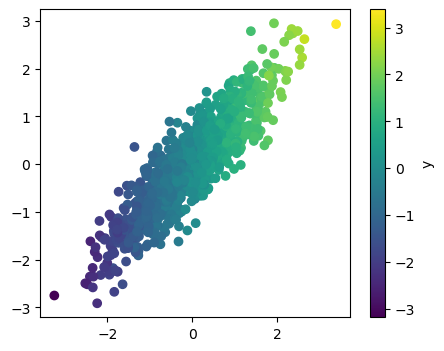

In [30]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5, 4) # Smaller default figure size

plt.figure()
X_full, y_full = generate_without_missing_values(1000)
plt.scatter(X_full[:, 0], X_full[:, 1], c=y_full)
plt.colorbar(label='y')

### The missing-values mechanism

We now consider missing completely at random settings (MCAR): the missingness
is completely independent from the values.

In [31]:
def generate_mcar(n_samples, missing_rate=.5, rng=42):
    X, y = generate_without_missing_values(n_samples, rng=rng)
    if not isinstance(rng, np.random.RandomState):
        rng = np.random.RandomState(rng)

    M = rng.binomial(1, missing_rate, (n_samples, 2))
    np.putmask(X, M, np.nan)

    return X, y

A quick plot to look at the data:

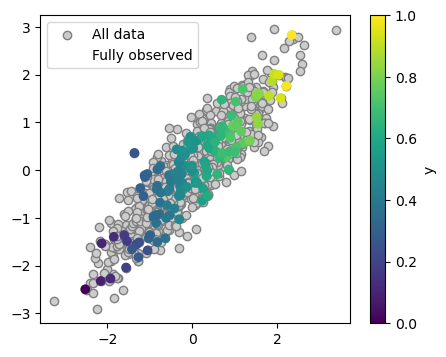

In [32]:
X, y = generate_mcar(500)

plt.figure()
plt.scatter(X_full[:, 0], X_full[:, 1], color='.8', ec='.5', label='All data')
plt.colorbar(label='y')
plt.scatter(X[:, 0], X[:, 1], c=y, label='Fully observed')
plt.legend()

We can see that the distribution of the fully-observed data is the same
as that of the original data.

### Conditional Imputation with the IterativeImputer

#### Visualization

As the data is MCAR (a fortiori MAR), an imputer can use the
conditional dependencies between the observed and the missing values to
impute the missing values.

We'll use the IterativeImputer, a good imputer, but it needs to be enabled.



In [33]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
iterative_imputer = IterativeImputer()

Let us try the imputer on the small data used for visualization. For now, we have not defined train and test sets, we only care about visualization. So we will just fit the imputer on `X` and impute `X`. 

**The imputation is learned by fitting the imputer on the data with
missing values:**



In [36]:
#TODO
iterative_imputer.fit(X)

IterativeImputer()

**The data are imputed with the transform method:**

In [37]:
#TODO
X_imputed = iterative_imputer.transform(X)

We can display the imputed data as our previous visualization



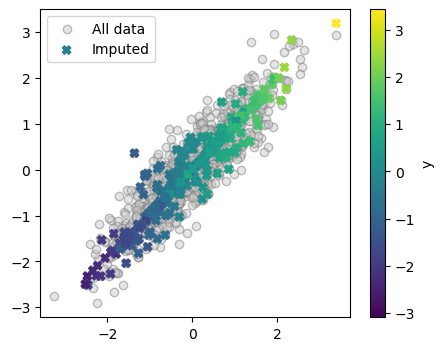

In [38]:
plt.figure()
plt.scatter(X_full[:, 0], X_full[:, 1], color='.8', ec='.5',
            label='All data', alpha=.5)
plt.scatter(X_imputed[:, 0], X_imputed[:, 1], c=y, marker='X',
            label='Imputed')
plt.colorbar(label='y')
plt.legend()

We can see that the imputer did a fairly good job at recovering the
conditional expectation.

#### Supervised learning

Given that the relationship between the fully-observed X and y is a
linear relationship, it seems natural to use a linear model for
prediction. It must be adapted to missing values using imputation.

To use it in supervised setting, we will pipeline it with a linear
model, using a ridge, which is a good default linear model.



In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV

#TODO
iterative_and_ridge = make_pipeline(IterativeImputer(), RidgeCV())

We can evaluate the model performance in a cross-validation loop
(for better evaluation accuracy, we increase slightly the number of
folds to 10)



In [40]:
from sklearn.model_selection import cross_val_score

#TODO
scores_iterative_and_ridge = cross_val_score(
    iterative_and_ridge, X, y, cv=10)

scores_iterative_and_ridge

array([0.61639853, 0.5814862 , 0.70136887, 0.64571923, 0.58785589,
       0.79618649, 0.65278055, 0.8454113 , 0.81722841, 0.76948479])

**Computational cost**: One drawback of the IterativeImputer to keep in
mind is that its computational cost can become prohibitive for large
datasets (it has a bad computational scalability).



### Mean imputation with the SimpleImputer

#### Visualization

We now try a simple imputer, the imputation by the mean:

In [41]:
from sklearn.impute import SimpleImputer

# TODO
mean_imputer = SimpleImputer()
X_imputed = mean_imputer.fit_transform(X)

A quick visualization reveals a distortion of the distribution:



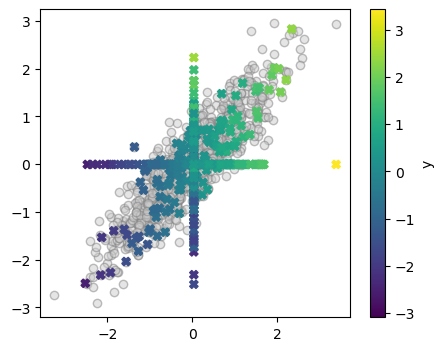

In [42]:
plt.figure()
plt.scatter(X_full[:, 0], X_full[:, 1], color='.8', ec='.5',
            label='All data', alpha=.5)
plt.scatter(X_imputed[:, 0], X_imputed[:, 1], c=y, marker='X',
            label='Imputed')
plt.colorbar(label='y')

#### Supervised learning

Evaluating the prediction pipeline with cross-validation:

In [43]:
#TODO
mean_and_ridge = make_pipeline(SimpleImputer(), RidgeCV())
scores_mean_and_ridge = cross_val_score(
    mean_and_ridge, X, y, cv=10)

scores_mean_and_ridge

array([0.58596256, 0.55215184, 0.61081314, 0.55282029, 0.54053836,
       0.64325051, 0.60147921, 0.84188079, 0.68152965, 0.67441335])

### Supervised learning without imputation

HistGradientBoosting models are based on trees, which can be
adapted to model directly missing values. Let's compute their cross-validation
scores:



In [44]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

#TODO
score_hist_gradient_boosting = cross_val_score(
    HistGradientBoostingRegressor(), X, y, cv=10)

score_hist_gradient_boosting

array([0.61170698, 0.56911116, 0.635685  , 0.62752111, 0.58094569,
       0.71569692, 0.62359162, 0.83829684, 0.81283438, 0.74080482])

### Recap: which pipeline predicts well on our small data?

Let's plot the scores to see things better (change the names of the lists
containing the scores according to what you used above).

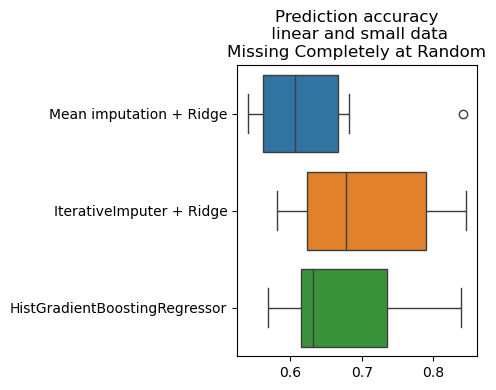

In [45]:
import pandas as pd
import seaborn as sns

scores = pd.DataFrame({'Mean imputation + Ridge': scores_mean_and_ridge,
             'IterativeImputer + Ridge': scores_iterative_and_ridge,
             'HistGradientBoostingRegressor': score_hist_gradient_boosting,
    })

sns.boxplot(data=scores, orient='h')
plt.title('Prediction accuracy\n linear and small data\n'
          'Missing Completely at Random')
plt.tight_layout()

### Prediction performance with more samples.

Let us compare models in regimes where there is plenty of data:

In [46]:
X, y = generate_mcar(n_samples=20000)

Iterative imputation and linear model:



In [47]:
#TODO
scores_iterative_and_ridge= cross_val_score(
    iterative_and_ridge, X, y, cv=10)

Mean imputation and linear model:



In [48]:
#TODO
scores_mean_and_ridge = cross_val_score(
    mean_and_ridge, X, y, cv=10)

And now the HistGradientBoostingRegressor, with mean imputation or using its
native handling of missing values:

In [49]:
#TODO
mean_and_hist_gradient_boosting = make_pipeline(
    SimpleImputer(), HistGradientBoostingRegressor())

score_mean_and_hist_gradient_boosting = cross_val_score(
    mean_and_hist_gradient_boosting, X, y, cv=10)

score_hist_gradient_boosting = cross_val_score(
    HistGradientBoostingRegressor(), X, y, cv=10)

We plot the results



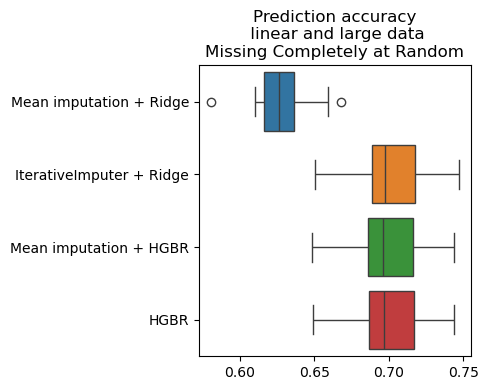

In [50]:
scores = pd.DataFrame({'Mean imputation + Ridge': scores_mean_and_ridge,
             'IterativeImputer + Ridge': scores_iterative_and_ridge,
             'Mean imputation + HGBR': score_mean_and_hist_gradient_boosting,
             'HGBR': score_hist_gradient_boosting,
    })

sns.boxplot(data=scores, orient='h')
plt.title('Prediction accuracy\n linear and large data\n'
          'Missing Completely at Random')
plt.tight_layout()

In a linear data-generating mechanism, the quality of imputation matters when
a linear model is used for predictions. The mean imputation thus underperform
the iterative imputer. A poor imputation quality can nonetheless be
compensated by the use of a more powerful predictive model.

Even in the case of a linear data-generating mechanism, the
optimal prediction on data imputed by a constant
is a piecewise affine function with 2^d regions (
http://proceedings.mlr.press/v108/morvan20a.html ). The
larger the dimensionality (number of features), the more a
imperfect imputation is hard to approximate with a simple model.

## When the predictive model is non-linear

We now modify a bit the example above to consider the situation where y is a
non-linear function of X.

In [51]:
n_samples = 20000
X, y= generate_mcar(n_samples, missing_rate=.5)
y = y**2

In this case, using a linear model after the imputation does not make sense.
We can however compare different imputations with gradient boosting regression
trees and see how much imputation matters in this case.

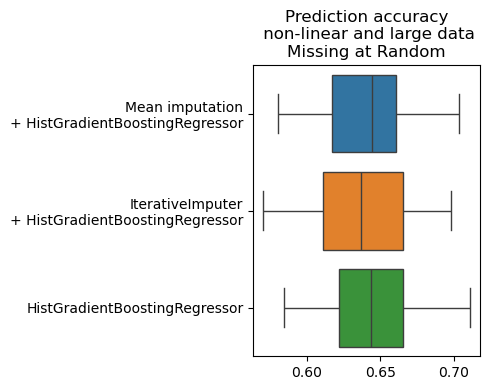

In [52]:
#TODO

scores = dict()

# IterativeImputer and non-linear model
iterative_and_gb = make_pipeline(IterativeImputer(),
                            HistGradientBoostingRegressor())
scores['Mean imputation\n+ HistGradientBoostingRegressor'] = cross_val_score(
    iterative_and_gb, X, y, cv=10)

# Mean imputation and non-linear model
mean_and_gb = make_pipeline(SimpleImputer(),
                            HistGradientBoostingRegressor())
scores['IterativeImputer\n+ HistGradientBoostingRegressor'] = cross_val_score(
    mean_and_gb, X, y, cv=10)

# And now the HistGradientBoostingRegressor, whithout imputation
scores['HistGradientBoostingRegressor'] = cross_val_score(
    HistGradientBoostingRegressor(), X, y, cv=10)

# We plot the results
sns.boxplot(data=pd.DataFrame(scores), orient='h')
plt.title('Prediction accuracy\n non-linear and large data\n'
          'Missing at Random')
plt.tight_layout()

We can see that when the model is not linear, the quality of the imputation may
not matter as much as it does for a linear model. In our case, the imputation
is not the most important step of the pipeline, rather
**what is important is to use a powerful predictive model**.


## Using a predictor for the fully-observed case

We use again our setting with a non-linear function of the data.

In [53]:
n_samples = 20000

X, y = generate_mcar(n_samples, missing_rate=.5)
y = y**2

Suppose we have been able to train a predictive model that works on
fully-observed data:



In [54]:
X_full, y_full = generate_without_missing_values(n_samples)
y_full = y_full**2
full_data_predictor = HistGradientBoostingRegressor()
full_data_predictor.fit(X_full, y_full)

cross_val_score(full_data_predictor, X_full, y_full)

array([0.96818534, 0.9666681 , 0.965068  , 0.96972809, 0.96862118])

The cross validation reveals that the predictor achieves an excellent
explained variance; it is a near-perfect predictor on fully observed
data



Now we turn to data with missing values. We use imputation to build a completed
data that looks like the fully-observed data:

In [55]:
iterative_imputer = IterativeImputer()
X_imputed = iterative_imputer.fit_transform(X)

The full data predictor can be used on the imputed data



In [56]:
from sklearn import metrics
metrics.r2_score(y, full_data_predictor.predict(X_imputed))

0.535587194628128

This prediction is not as good as on the full data, but this is
expected, as missing values lead to a loss of information. We can
compare it to a model trained to predict on data with missing values.

In [57]:
X_train, y_train = generate_mcar(n_samples, missing_rate=.5)
y_train = y_train**2
na_predictor = HistGradientBoostingRegressor()
na_predictor.fit(X_train, y_train)

metrics.r2_score(y, na_predictor.predict(X))

0.6560851210583205

The model trained on data with missing values works significantly
better than the one trained on fully-observed data.

**Only for linear mechanism is the model on full data also optimal for
perfectly imputed data**. When the function linking X to y has
curvature, this curvature turns uncertainty resulting from missingness
into bias.

## Experimenting with a (semi-) real dataset

Previous experiments give useful insights but were limited to Gaussian data,
and a dimension of two. We will now use a more realistic dataset, derived from
the
[wine quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality).

While the covariates of this dataset are not simulated, the missing values are.
We provide two versions of the dataset with two different missing data
mechanisms.

Let's first load the data:

In [ ]:
import pickle

file1 = open("./data/semi_simu1",'rb')
semi_simu1 = pickle.load(file1)

file2 = open("./data/semi_simu2",'rb')
semi_simu2 = pickle.load(file2)

X1, y1 = semi_simu1
X2, y2 = semi_simu2

In [ ]:
print(X1.shape, y1.shape)
print(X2.shape, y2.shape)

Taking inspiration from the analysis on the toy datsets above, and refering to
the methods presented in the course, try to obtain the best possible
predictions in cross-validation for these datasets.

In [ ]:
#TODO
